In [1]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
import sys
from tifffile import imread

# Change this folder to where the cloned `alignment` repository is
sys.path.insert(0, '/Users/minelarinel/alignment')

from alignment import minmax_scaler
from registration import sitkalignment

logging.getLogger('matplotlib').setLevel(logging.ERROR)

cv2 not available


#### To align the hindbrain to mapzebrain atlas, we will use a plane in the reference hindbrain stack.

In [2]:
# Folder where the experiment folders are
# CHANGE THIS
data_folder = Path(r'/Volumes/Rapid/Arinel_et_al_2025/Data/alignment/hindbrain')

# Target data - Reference hindbrain stack
target_img_path = Path(r'./reference_images/hindbrain/anatomystack-000_Cycle00001_Ch2_000001.ome.tif')

# Reference data - mapzebrain atlas
source_img_path = Path(r'./reference_images/hindbrain/mapzebrain/T_AVG_HuCD.tif')

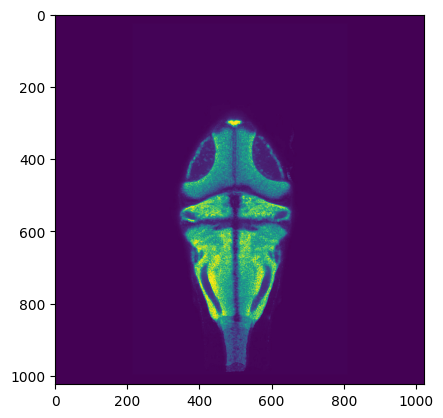

In [3]:
# Load the source image
anatomy_plane_of_interest = 297 # need to only choose one plane

source_img_stack = imread(source_img_path)

source_img = source_img_stack[anatomy_plane_of_interest, :, :]
source_img = sitkalignment.embed_image(source_img, 1024) # matching image sizes to 1024x1024

source_img = source_img / source_img.max() # rescaling pixel brightness
source_img *= 2**12

plt.imshow(source_img)

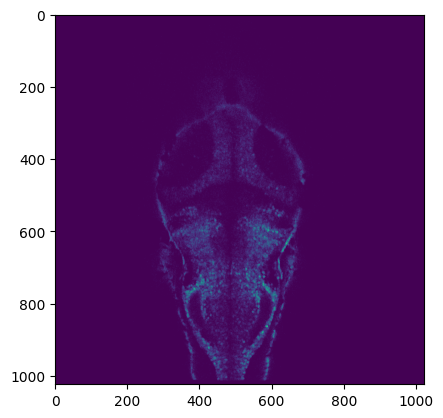

In [4]:
# Load the target image
target_plane_of_interest = 9 # need to only choose one plane

target_img_stack = imread(target_img_path)

target_img = target_img_stack[target_plane_of_interest, :, :]
target_img = sitkalignment.embed_image(target_img, 1024) # matching image sizes to 1024x1024

target_img = target_img / target_img.max() # rescaling pixel brightness
target_img *= 2**12

plt.imshow(target_img)

In [ ]:
# Change the vmin and vmax settings for better visualization and better alignment
# Increasing the contrast of landmarks helps with the alignment
source_vmin = 700
source_vmax = source_img.max()
target_vmin = 0
target_vmax = 800

_source_img = minmax_scaler(source_img, vmin=source_vmin, vmax=source_vmax)
_plot_img = minmax_scaler(target_img, vmin=target_vmin, vmax=target_vmax)

# Saving the reverse alignment in the hindbrain alignment folder
save_path = os.path.join(data_folder, "alignment_rev")

# Perform the alignment
# Can change scalePenalty and iterations. Increase iterations to get better result. Lower scale penalty if you want more warp.
registered_image = sitkalignment.register_image2(_plot_img, _source_img, save_path, scalePenalty=50, iterations=(10000, 500))

# Visualize the alignment
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
ax[0].imshow(
	target_img,
	cmap="gray",
	vmin=target_vmin,
	vmax=target_vmax
)
ax[1].imshow(
	registered_image,
	cmap="gray",
	vmin=source_vmin, vmax=source_vmax
)
[a.axis("off") for a in ax]
merge = np.zeros(
	(target_img.shape[0], target_img.shape[1], 3)
)  # assumes same size images
merge[:, :, 0] = 2 * target_img / target_img.max()
merge[:, :, 1] = 2 * registered_image / registered_image.max()
ax[-1].imshow(merge)
ax[0].set_title("target")
ax[1].set_title("reference")
ax[-1].set_title("merge")
plt.show()

# Find best target plane

Gather all target images that you align to the source image into a list if you want to run z alignment

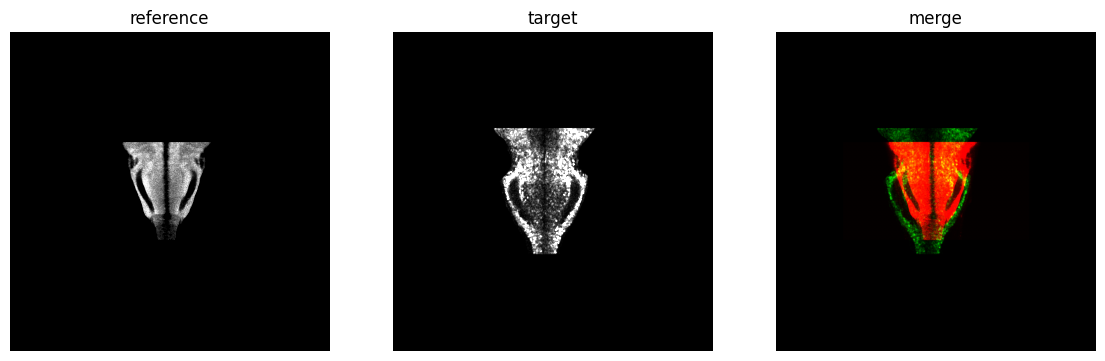

In [66]:
# visualize images
target_vmin = 0
target_vmax = 800
source_vmin = 700
source_vmax = source_img.max()
plot_img_line_xval = 0  # blocking out top of functional image with 0's
source_img_line_xval = 0  # blocking out top of reference image with 0's

########################################

plot_img = target_img

fig, ax = plt.subplots(1, 3, figsize=(14, 6))

_plot_img = plot_img.copy()
_plot_img[0:plot_img_line_xval] = 0

_source_img = source_img.copy()
_source_img[0:source_img_line_xval] = 0

ax[0].imshow(
    _source_img,
    cmap="gray",
    vmin=source_vmin,
    vmax=source_vmax  # max is 4096
)
ax[1].imshow(
    _plot_img, 
    cmap="gray",
    vmin=target_vmin,
    vmax=target_vmax  # max is 4096
)

[a.axis("off") for a in ax]

merge = np.zeros(
    (_source_img.shape[0], _source_img.shape[1], 3)
)  # assumes same size images
merge[:, :, 0] = 2 * _source_img / _source_img.max()
merge[:, :, 1] = 2 * _plot_img / _plot_img.max()
ax[-1].imshow(merge)

ax[0].set_title("reference")
ax[1].set_title("target")
ax[-1].set_title("merge")
plt.show()

In [67]:
_source_img = minmax_scaler(_source_img, vmin=source_vmin, vmax=source_vmax)
_plot_img = minmax_scaler(_plot_img, vmin=target_vmin, vmax=target_vmax)

# Reverse alignment

In [ ]:
%%time
# saving the reverse alignment in this path (in the same folder as the functional volume)
save_path = data_folder.joinpath("reference_brain", "alignment_rev")

# register_image2 is the correct function to use

# can change scalePenalty and iterations
# increase iterations to get better result
# lower scale penalty if you want more warp

scale_penalties = [50]
iterations = [(10000, 500)]

registered_images = list()
for sp in scale_penalties:
	for it in iterations:
		registered_image = sitkalignment.register_image2(_plot_img, _source_img, save_path, scalePenalty=sp, iterations=it)
		registered_images.append(registered_image)

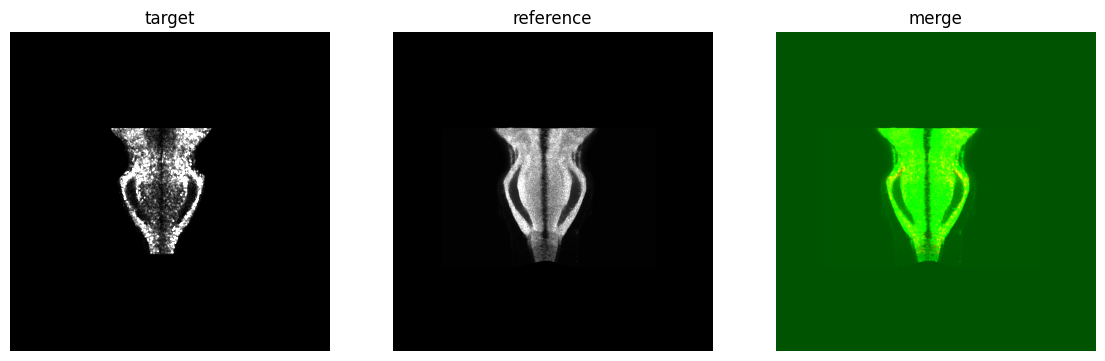

In [85]:
for registered_image in registered_images:
	fig, ax = plt.subplots(1, 3, figsize=(14, 6))

	ax[0].imshow(
		plot_img,
		cmap="gray",
		vmin=target_vmin, vmax=target_vmax
	)
	ax[1].imshow(
		registered_image,
		cmap="gray",
		vmin=source_vmin, vmax=source_vmax
	)

	[a.axis("off") for a in ax]

	merge = np.zeros(
		(plot_img.shape[0], plot_img.shape[1], 3)
	)  # assumes same size images
	merge[:, :, 0] = 2 * plot_img / plot_img.max()
	merge[:, :, 1] = 2 * registered_image / registered_image.max()
	ax[-1].imshow(merge)

	ax[0].set_title("target")
	ax[1].set_title("reference")
	ax[-1].set_title("merge")
	plt.show()

## Align points to the mapzebrain atlas

### Plot randomly selected neurons onto the mapzebrain atlas to confirm location

In [ ]:
with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the unrolled_temporal.h5 file
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))

			# Randomly select n_points number of points and transform them
			n_points = 10
			plane = 2

			mypoints = list()
			coms = random.sample(list(df[df.plane == plane]["com_aligned"]), n_points)
			for x, y in coms:
				mypoints.append((x, y))
				
			rev_points = sitkalignment.transform_points(Path(save_path), mypoints)

			# Plot the original points on the target image vs. transformed points on the reference image
			fig, ax = plt.subplots(1, 2, figsize=(14, 6))
			ax[0].imshow(
				target_img,
				cmap="gray",
				vmin=target_vmin,
				vmax=target_vmax 
			)
			for p in mypoints:
				ax[0].scatter(p[0], p[1])
			ax[0].set_title('original points')
			ax[1].imshow(
				source_img,
				cmap="gray",
				vmin=source_vmin,
				vmax=source_vmax,
			)
			ax[1].set_title('reverse transformed points')
			for p in rev_points:
				ax[1].scatter(p[0], p[1])
			[a.axis("off") for a in ax]
			plt.show()

## Testing this alignment on multiple planes

In [ ]:
# visualize images
n_points = 10
target_plane_idxs = [4, 6, 8, 10, 12]
source_plane_idxs = [322, 314, 297, 286, 275]

for plane, idx in enumerate(target_plane_idxs):
	mypoints = list()

	coms = random.sample(list(df[df.plane == plane]["com_aligned"]), n_points)
	for x, y in coms:
		mypoints.append((x, y))
		
	rev_points = sitkalignment.transform_points(Path(save_path), mypoints)

	fig, ax = plt.subplots(1, 2, figsize=(14, 6))

	target_plane = target_img_stack[idx, :, :]
	target_plane = sitkalignment.embed_image(target_plane, 1024) # matching image sizes to 1024x1024
	target_plane = target_plane / target_plane.max() # rescaling pixel brightness
	target_plane *= 2**12
	
	ax[0].imshow(
		target_plane,
		cmap="gray",
		vmin=target_vmin,
		vmax=target_vmax,
	)
	for p in mypoints:
		ax[0].scatter(p[0],p[1])
	ax[0].set_title('original points')

	source_plane = source_img_stack[source_plane_idxs[plane], :, :]
	source_plane = sitkalignment.embed_image(source_plane, 1024) # matching image sizes to 1024x1024
	source_plane = source_plane / source_plane.max() # rescaling pixel brightness
	source_plane *= 2**12

	ax[1].imshow(
		source_plane,
		cmap="gray",
		vmin=source_vmin,
		vmax=source_vmax,
	)
	ax[1].set_title('reverse transformed points')
	for p in rev_points:
		ax[1].scatter(p[0],p[1])

	[a.axis("off") for a in ax]
	plt.show()

In [ ]:
# Update the unrolled_temporal.h5 dataframe with the reverse transformed points
# Align the points in the embedded space to the reference image space
x_offset = int(np.round((1024-source_img_stack.shape[2])/2))
y_offset = int(np.round((1024-source_img_stack.shape[1])/2))

with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the unrolled_temporal.h5 file to add the reverse transformed points
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))
			df["com_aligned_mapzebrain"] = None
			
			for i, row in df.iterrows():
				rev_point = sitkalignment.transform_points(Path(save_path), [(row["com_aligned"][0], row["com_aligned"][1])])
				df.at[i, "com_aligned_mapzebrain"] = (rev_point[0][0] - x_offset, rev_point[0][1] - y_offset)

			df.to_hdf(os.path.join(exp_folder, "unrolled_temporal.h5") , key='unrolled_temporal', mode='w')

## Assign neurons to brain regions

In [ ]:
masks_folder = r'./reference_images/hindbrain/mapzebrain/mapZebrain__regions'
plane_idxs = [322, 314, 297, 286, 275]

In [ ]:
with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the unrolled_temporal.h5 file to add the reverse transformed points
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))

			# Add a new column to the dataframe to store the region names
			df["region_aligned_mapzebrain"] = None

			with os.scandir(masks_folder) as entries:
				for entry in entries:
					if not entry.name.startswith("."):
						mask_name = entry.name[:-4]
						mask_stack = imread(entry.path)

						# The reference brain is cut off at the bottom, so we need to crop the mask stack
						cropped_mask = mask_stack[plane_idxs, 578:892, :]

						for plane in range(len(plane_idxs)):
							# Only proceed if there are any positive pixels in the mask
							if len(np.where(cropped_mask[plane, :, :] > 0)[0]) > 0:
								# Determine the rows where the com_aligned_mapzebrain x, y coordinate values are within the mask
								for i, (x, y) in enumerate(df["com_aligned_mapzebrain"]):
									if df.loc[i, "plane"] == plane and cropped_mask[plane, y, x] > 0:
										if df.at[i, "region_aligned_mapzebrain"] is not None:
											df.at[i, "region_aligned_mapzebrain"].append(mask_name)
										else:
											df.at[i, "region_aligned_mapzebrain"] = [mask_name]

			df.to_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"), key='unrolled_temporal', mode='w')

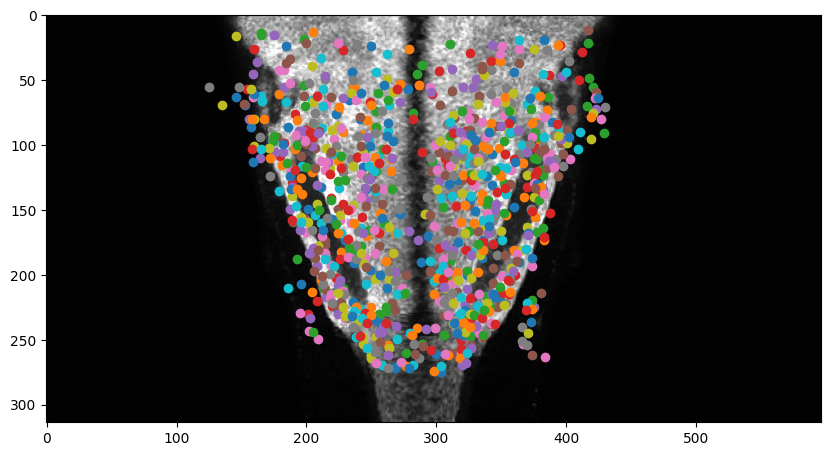

In [ ]:
# Visualize the aligned points on the reference image
plane = 2
region = "vagal_sensory_lobe"

plt.figure(figsize=(10, 10))
plt.imshow(source_img_stack[plane_idxs[plane], :, :], cmap="gray")

with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the unrolled_temporal.h5 file to add the reverse transformed points
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))

			for i, row in df[df.plane == plane].iterrows():
				if row["region_aligned_mapzebrain"] is not None:
					plt.scatter(row["com_aligned_mapzebrain"][0], row["com_aligned_mapzebrain"][1])

## Assign a single region to each neuron

Since the region_aligned_mapzebrain column has multiple regions in a list from general to more specific regions, have another column to later on filter by with the regions of interest.

In [ ]:
# Most specific regions
first_level_regions = ["medial_octavolateralis_nucleus", "area_postrema", "facial_motor_nucleus", "vagal_sensory_lobe", 
				  "vagus_motor_nucleus"]

# Higher level regions
second_level_regions = ["intermediate_dorsal_medulla_oblongata", "intermediate_ventral_medulla_oblongata_(entire)", "inferior_dorsal_medulla_oblongata",
						"superior_dorsal_medulla_oblongata"]

with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the unrolled_temporal.h5 file
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))

			# Add a new column to the dataframe to store the region names
			df["single_region"] = None

			for i, row in df.iterrows():
				regions = row["region_aligned_mapzebrain"]

				if regions is not None:
					# Check first level regions
					for first_level_region in first_level_regions:
						if first_level_region in regions:
							df.at[i, "single_region"] = first_level_region
							break

					# Check second level regions if no first level region found
					if df.at[i, "single_region"] is None:
						for second_level_region in second_level_regions:
							if second_level_region in regions:
								df.at[i, "single_region"] = second_level_region
								break

			df.to_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"), key='unrolled_temporal', mode='w')